# Resource competition: light and Fe in the ACC region of the Southern Ocean

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob

import xarray as xr
import numpy as np

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
import math
import cmocean

## first, make seasonal-biomass weighted means of temp, Fe, par

#### SIZ 1920s

In [2]:
file = '/glade/scratch/kristenk/CESM-LE-output/seasonal_upper_50m_means_SIZ-1920s.nc'
ds_siz_1920s=xr.open_dataset(file)

In [3]:
ds_siz_1920s['phytoC_50m_zint'] = ds_siz_1920s.spC_50m_zint + ds_siz_1920s.diatC_50m_zint

#### SIZ 2090s

In [4]:
file = '/glade/scratch/kristenk/CESM-LE-output/seasonal_upper_50m_means_SIZ-2090s.nc'
ds_siz_2090s=xr.open_dataset(file)

In [5]:
ds_siz_2090s['phytoC_50m_zint'] = ds_siz_2090s.spC_50m_zint + ds_siz_2090s.diatC_50m_zint

In [6]:
variables = ['Fe_avg_50m','PAR_avg_50m','TEMP_50m_mean'] #'spC_50m_zint','diatC_50m_zint']

### Calculate seasonal-biomass weighted means for each region/epoch

In [7]:
SIZ_1920s_Cweight_ds = xr.Dataset()

for var in variables:

    work = ds_siz_1920s[var].isel(season=0) * ds_siz_1920s.phytoC_50m_zint.isel(season=0)
    work = work + ds_siz_1920s[var].isel(season=1) * ds_siz_1920s.phytoC_50m_zint.isel(season=1)
    work = work + ds_siz_1920s[var].isel(season=2) * ds_siz_1920s.phytoC_50m_zint.isel(season=2)
    work = work + ds_siz_1920s[var].isel(season=3) * ds_siz_1920s.phytoC_50m_zint.isel(season=3)
    phytoC_sum = ds_siz_1920s.phytoC_50m_zint.sum(dim='season')

    SIZ_1920s_Cweight_ds[var] = (work/phytoC_sum).values
SIZ_1920s_Cweight_ds

<xarray.Dataset>
Dimensions:        ()
Data variables:
    Fe_avg_50m     float64 0.000162
    PAR_avg_50m    float64 11.95
    TEMP_50m_mean  float64 -1.253

In [8]:
SIZ_2090s_Cweight_ds = xr.Dataset()

for var in variables:

    work = ds_siz_2090s[var].isel(season=0) * ds_siz_2090s.phytoC_50m_zint.isel(season=0)
    work = work + ds_siz_2090s[var].isel(season=1) * ds_siz_2090s.phytoC_50m_zint.isel(season=1)
    work = work + ds_siz_2090s[var].isel(season=2) * ds_siz_2090s.phytoC_50m_zint.isel(season=2)
    work = work + ds_siz_2090s[var].isel(season=3) * ds_siz_2090s.phytoC_50m_zint.isel(season=3)
    phytoC_sum = ds_siz_2090s.phytoC_50m_zint.sum(dim='season')

    SIZ_2090s_Cweight_ds[var] = (work/phytoC_sum).values
SIZ_2090s_Cweight_ds

<xarray.Dataset>
Dimensions:        ()
Data variables:
    Fe_avg_50m     float64 0.0001523
    PAR_avg_50m    float64 16.68
    TEMP_50m_mean  float64 -0.02824

In [9]:
annotations = ds_siz_1920s.season.values

## start work on resource competition, parameter values are from CESM1

#### cycle through values and calculate growth rate for sp and diat, taking difference

# Fe and PAR

### SIZ 2090s temp

In [10]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
PAR_vals = np.arange(0,25,0.25)
T = SIZ_2090s_Cweight_ds.TEMP_50m_mean

#calculate tfunc
Tfunc = q10**((T - Tref) / 10.)

## initialize empty matrices
sp_growthrate_FePAR_SIZ2090s = np.full((100,100),np.nan)
diat_growthrate_FePAR_SIZ2090s = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_FePAR_SIZ2090s[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_FePAR_SIZ2090s[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_FePAR_SIZ2090s = xr.DataArray(sp_growthrate_FePAR_SIZ2090s,dims=('par_vals','fe_vals'))
diat_growthrate_FePAR_SIZ2090s = xr.DataArray(diat_growthrate_FePAR_SIZ2090s,dims=('par_vals','fe_vals'))

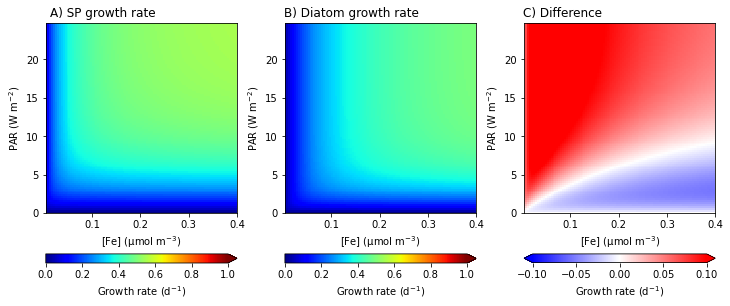

In [11]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('A) SP growth rate', x=0.3)
pc=ax.pcolormesh(Fe_vals*1000, PAR_vals, sp_growthrate_FePAR_SIZ2090s,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
# labels = ['0.1','0.20','0.30','0.40']
# ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(1,3,2)
ax.set_title('B) Diatom growth rate', x=0.35)
pc=ax.pcolormesh(Fe_vals*1000, PAR_vals, diat_growthrate_FePAR_SIZ2090s,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
# labels = ['0.1','0.20','0.30','0.40']
# ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(1,3,3)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(Fe_vals*1000, PAR_vals, sp_growthrate_FePAR_SIZ2090s-diat_growthrate_FePAR_SIZ2090s,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
# labels = ['0.1','0.20','0.30','0.40']
# ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal', ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 

plt.subplots_adjust(wspace=0.25)

#fig.savefig('/glade/work/kristenk/figs/example_resource_comp.png', bbox_inches='tight', dpi=300, format='png');

In [12]:
SIZ_plotvals_2090s = xr.concat([ds_siz_2090s, ds_siz_2090s.isel(season=0)],dim='season')
SIZ_plotvals_1920s = xr.concat([ds_siz_1920s, ds_siz_1920s.isel(season=0)],dim='season')

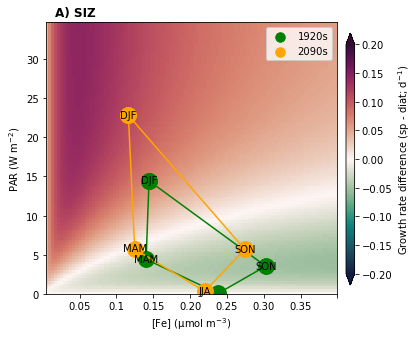

In [20]:
fig = plt.figure(figsize=(6,5))


######################################################### ACC
ax = fig.add_subplot(1,1,1)

ax.set_title('A) SIZ',x=0.1,y=1, fontsize=12, fontweight='bold')
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_FePAR_SIZ2090s-diat_growthrate_FePAR_SIZ2090s,cmap=cmocean.cm.curl,vmin=-0.2,vmax=0.2)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')

#1920s
#s = [ACC_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_1920s.Fe_avg_50m.values,SIZ_plotvals_1920s.PAR_avg_50m.values,
        marker='o',s=250,color='green',label='1920s', zorder=1)
ax.plot(SIZ_plotvals_1920s.Fe_avg_50m.values,SIZ_plotvals_1920s.PAR_avg_50m.values,
        color='green',zorder=1)

# #2090s
#s = [ACC_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_2090s.Fe_avg_50m.values,SIZ_plotvals_2090s.PAR_avg_50m.values,
        marker='o',s=250,color='orange',label='2090s',zorder=2)
ax.plot(SIZ_plotvals_2090s.Fe_avg_50m.values,SIZ_plotvals_2090s.PAR_avg_50m.values,
        color='orange',zorder=2)

## add season labels
plt.annotate(annotations[0], (ds_siz_1920s.Fe_avg_50m.values[0], ds_siz_1920s.PAR_avg_50m.values[0]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_1920s.Fe_avg_50m.values[1], ds_siz_1920s.PAR_avg_50m.values[1]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_1920s.Fe_avg_50m.values[2], ds_siz_1920s.PAR_avg_50m.values[2]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_1920s.Fe_avg_50m.values[3], ds_siz_1920s.PAR_avg_50m.values[3]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[0], (ds_siz_2090s.Fe_avg_50m.values[0], ds_siz_2090s.PAR_avg_50m.values[0]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_2090s.Fe_avg_50m.values[1], ds_siz_2090s.PAR_avg_50m.values[1]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_2090s.Fe_avg_50m.values[2], ds_siz_2090s.PAR_avg_50m.values[2]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_2090s.Fe_avg_50m.values[3], ds_siz_2090s.PAR_avg_50m.values[3]-0.3), fontsize=10,ha='center')

ax.legend(markerscale=0.6,scatterpoints=1, fontsize=10)
# ### add x axis labels in nmol/m3
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35']
ax.set_xticklabels(labels)


### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');

# for x in [100, 200, 300, 400, 500]:
#     plt.scatter([], [], c='gray', alpha=1, s=x, label=str(x), marker='o',edgecolors='black')
# # legend2 = ax.legend(loc='upper center', bbox_to_anchor=(0.8, 0.8), ncol=1, fancybox=True, shadow=False, title='Biomass')

# legend2 = plt.legend(loc="upper right", title="(mmol m$^{-2}$)", bbox_to_anchor=(-15, 1.02),
#                      fancybox=True, labelspacing=1.5, borderpad=1.3)

#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');

# Fe and Temperature

### SIZ 2090s PAR

In [27]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
Temp_vals = np.arange(-2,2,0.04)
PAR = SIZ_2090s_Cweight_ds.PAR_avg_50m

## initialize empty matrices
sp_growthrate_FeT_SIZ2090s = np.full((100,100),np.nan)
diat_growthrate_FeT_SIZ2090s = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for T in Temp_vals: # j loop
        
        #calculate tfunc
        Tfunc = q10**((T - Tref) / 10.)
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_FeT_SIZ2090s[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_FeT_SIZ2090s[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_FeT_SIZ2090s = xr.DataArray(sp_growthrate_FeT_SIZ2090s,dims=('par_vals','fe_vals'))
diat_growthrate_FeT_SIZ2090s = xr.DataArray(diat_growthrate_FeT_SIZ2090s,dims=('par_vals','fe_vals'))

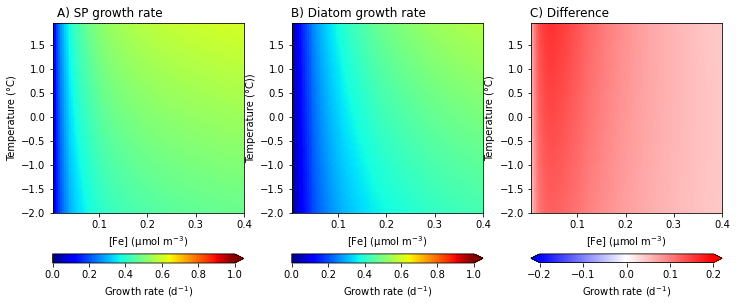

In [28]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('A) SP growth rate', x=0.3)
pc=ax.pcolormesh(Fe_vals*1000, Temp_vals, sp_growthrate_FeT_SIZ2090s,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(1,3,2)
ax.set_title('B) Diatom growth rate', x=0.35)
pc=ax.pcolormesh(Fe_vals*1000, Temp_vals, diat_growthrate_FeT_SIZ2090s,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('Temperature (°C))')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(1,3,3)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(Fe_vals*1000, Temp_vals, sp_growthrate_FeT_SIZ2090s-diat_growthrate_FeT_SIZ2090s,cmap='bwr',vmin=-0.2,vmax=0.2)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal') #, ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 

plt.subplots_adjust(wspace=0.25)

#fig.savefig('/glade/work/kristenk/figs/example_resource_comp.png', bbox_inches='tight', dpi=300, format='png');

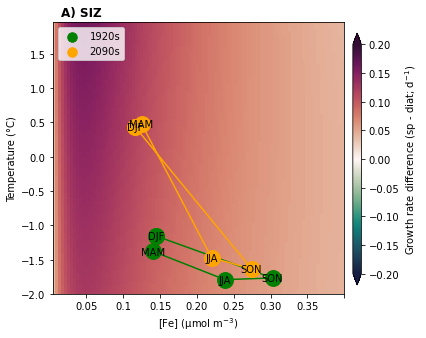

In [30]:
fig = plt.figure(figsize=(6,5))


######################################################### SIZ
ax = fig.add_subplot(1,1,1)

ax.set_title('A) SIZ',x=0.1,y=1, fontsize=12, fontweight='bold')
pc=ax.pcolormesh(Fe_vals, Temp_vals, sp_growthrate_FeT_SIZ2090s-diat_growthrate_FeT_SIZ2090s,cmap=cmocean.cm.curl,vmin=-0.2,vmax=0.2)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')

#1920s
#s = [ACC_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_1920s.Fe_avg_50m.values,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        marker='o',s=250,color='green',label='1920s', zorder=1)
ax.plot(SIZ_plotvals_1920s.Fe_avg_50m.values,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        color='green',zorder=1)

# #2090s
#s = [ACC_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_2090s.Fe_avg_50m.values,SIZ_plotvals_2090s.TEMP_50m_mean.values,
        marker='o',s=250,color='orange',label='2090s',zorder=2)
ax.plot(SIZ_plotvals_2090s.Fe_avg_50m.values,SIZ_plotvals_2090s.TEMP_50m_mean.values,
        color='orange',zorder=2)

## add season labels
plt.annotate(annotations[0], (ds_siz_1920s.Fe_avg_50m.values[0], ds_siz_1920s.TEMP_50m_mean.values[0]-0.05), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_1920s.Fe_avg_50m.values[1], ds_siz_1920s.TEMP_50m_mean.values[1]-0.05), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_1920s.Fe_avg_50m.values[2], ds_siz_1920s.TEMP_50m_mean.values[2]-0.05), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_1920s.Fe_avg_50m.values[3], ds_siz_1920s.TEMP_50m_mean.values[3]-0.05), fontsize=10,ha='center')

plt.annotate(annotations[0], (ds_siz_2090s.Fe_avg_50m.values[0], ds_siz_2090s.TEMP_50m_mean.values[0]-0.05), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_2090s.Fe_avg_50m.values[1], ds_siz_2090s.TEMP_50m_mean.values[1]-0.05), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_2090s.Fe_avg_50m.values[2], ds_siz_2090s.TEMP_50m_mean.values[2]-0.05), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_2090s.Fe_avg_50m.values[3], ds_siz_2090s.TEMP_50m_mean.values[3]-0.05), fontsize=10,ha='center')


ax.legend(loc="upper left",markerscale=0.6,scatterpoints=1, fontsize=10)
### add x axis labels in µmol/m3
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35']
ax.set_xticklabels(labels)



### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');


#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');

# Temp and PAR

### ACC 2090s Fe

In [31]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe = SIZ_2090s_Cweight_ds.Fe_avg_50m
Temp_vals = np.arange(-2,2,0.04)
PAR_vals = np.arange(0,35,0.35)

## initialize empty matrices
sp_growthrate_PART_SIZ2090s = np.full((100,100),np.nan)
diat_growthrate_PART_SIZ2090s = np.full((100,100),np.nan)

i=0
j=0

for PAR in PAR_vals: # i loop
    
    for T in Temp_vals: # j loop
        
        #calculate tfunc
        Tfunc = q10**((T - Tref) / 10.)
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_PART_SIZ2090s[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_PART_SIZ2090s[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_PART_SIZ2090s = xr.DataArray(sp_growthrate_PART_SIZ2090s,dims=('temp_vals','par_vals'))
diat_growthrate_PART_SIZ2090s = xr.DataArray(diat_growthrate_PART_SIZ2090s,dims=('temp_vals','par_vals'))

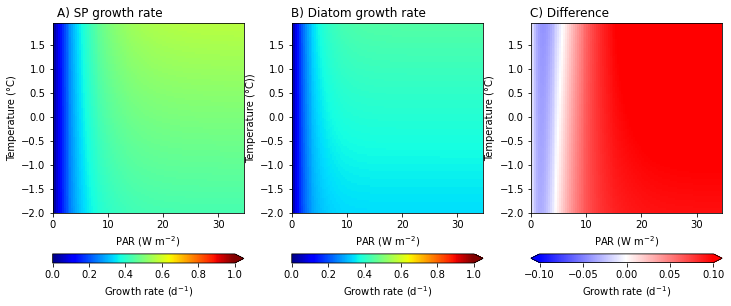

In [32]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('A) SP growth rate', x=0.3)
pc=ax.pcolormesh(PAR_vals, Temp_vals, sp_growthrate_PART_SIZ2090s,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('PAR (W m$^{-2}$)')
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(1,3,2)
ax.set_title('B) Diatom growth rate', x=0.35)
pc=ax.pcolormesh(PAR_vals, Temp_vals, diat_growthrate_PART_SIZ2090s,cmap='jet',vmin=0,vmax=1)
ax.set_ylabel('Temperature (°C))')
ax.set_xlabel('PAR (W m$^{-2}$)')
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(1,3,3)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(PAR_vals, Temp_vals, sp_growthrate_PART_SIZ2090s-diat_growthrate_PART_SIZ2090s,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('PAR (W m$^{-2}$)')
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal', ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 

plt.subplots_adjust(wspace=0.25)

#fig.savefig('/glade/work/kristenk/figs/example_resource_comp.png', bbox_inches='tight', dpi=300, format='png');

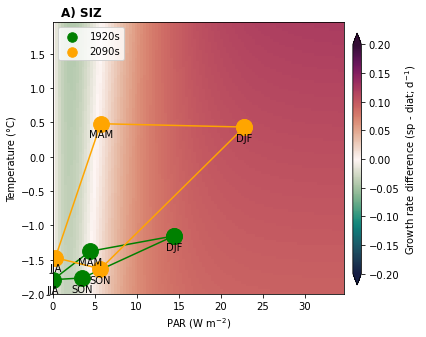

In [33]:
fig = plt.figure(figsize=(6,5))


######################################################### SIZ
ax = fig.add_subplot(1,1,1)

ax.set_title('A) SIZ',x=0.1,y=1, fontsize=12, fontweight='bold')
pc=ax.pcolormesh(PAR_vals, Temp_vals, sp_growthrate_PART_SIZ2090s-diat_growthrate_PART_SIZ2090s,cmap=cmocean.cm.curl,vmin=-0.2,vmax=0.2)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('PAR (W m$^{-2}$)')

#1920s
#s = [ACC_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_1920s.PAR_avg_50m.values,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        marker='o',s=250,color='green',label='1920s', zorder=1)
ax.plot(SIZ_plotvals_1920s.PAR_avg_50m.values,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        color='green',zorder=1)

# #2090s
#s = [ACC_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_2090s.PAR_avg_50m.values,SIZ_plotvals_2090s.TEMP_50m_mean.values,
        marker='o',s=250,color='orange',label='2090s',zorder=2)
ax.plot(SIZ_plotvals_2090s.PAR_avg_50m.values,SIZ_plotvals_2090s.TEMP_50m_mean.values,
        color='orange',zorder=2)

## add season labels
plt.annotate(annotations[0], (ds_siz_1920s.PAR_avg_50m.values[0], ds_siz_1920s.TEMP_50m_mean.values[0]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_1920s.PAR_avg_50m.values[1], ds_siz_1920s.TEMP_50m_mean.values[1]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_1920s.PAR_avg_50m.values[2], ds_siz_1920s.TEMP_50m_mean.values[2]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_1920s.PAR_avg_50m.values[3], ds_siz_1920s.TEMP_50m_mean.values[3]-0.2), fontsize=10,ha='center')

plt.annotate(annotations[0], (ds_siz_2090s.PAR_avg_50m.values[0], ds_siz_2090s.TEMP_50m_mean.values[0]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_2090s.PAR_avg_50m.values[1], ds_siz_2090s.TEMP_50m_mean.values[1]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_2090s.PAR_avg_50m.values[2], ds_siz_2090s.TEMP_50m_mean.values[2]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_2090s.PAR_avg_50m.values[3], ds_siz_2090s.TEMP_50m_mean.values[3]-0.2), fontsize=10,ha='center')

ax.legend(loc="upper left",markerscale=0.6,scatterpoints=1, fontsize=10)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');

#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');

### grazing rates

In [36]:
### Specify parameters
Tref = 30.
q10 = 2.0

Gmax_sp = 2.5 #per day
Gmax_diat = 1.95 #per day

km_sp = 1 #mmol/m3
km_diat = 0.84 #mmol/m3

## biomass ranges
diatC_vals = np.arange(0,3.5,0.035)
spC_vals = np.arange(0,3.5,0.035)

## initialize empty matrices
sp_grazingrate_siz2090s = np.full((100,100),np.nan)
diat_grazingrate_siz2090s = np.full((100,100),np.nan)

i=0
j=0

T=7

for spC in spC_vals: # i loop
    
    for diatC in diatC_vals: # j loop
        
        Tfunc = q10**((T - Tref) / 10.)
        
        ##### small phytoplankton
        spC_lim = (spC**2)/(spC**2 + km_sp**2)
        
        sp_grazingrate_siz2090s[j,i] = Gmax_sp * Tfunc * spC_lim
        
        #### diatoms
        diatC_lim = (diatC**2)/(diatC**2 + km_diat**2)
        
        diat_grazingrate_siz2090s[j,i] = Gmax_diat * Tfunc * diatC_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_grazingrate_siz2090s = xr.DataArray(sp_grazingrate_siz2090s,dims=('diatC_vals','spC_vals'))
diat_grazingrate_siz2090s = xr.DataArray(diat_grazingrate_siz2090s,dims=('diatC_vals','spC_vals'))

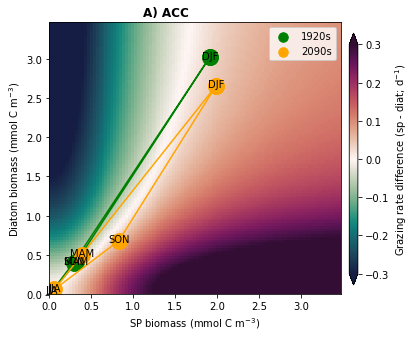

In [37]:
fig = plt.figure(figsize=(6,5))


######################################################### ACC
ax = fig.add_subplot(1,1,1)

ax.set_title('A) ACC',x=0.4,y=1, fontsize=12, fontweight='bold')
pc=ax.pcolormesh(spC_vals, diatC_vals, sp_grazingrate_siz2090s-diat_grazingrate_siz2090s,cmap=cmocean.cm.curl,vmin=-0.3,vmax=0.3)
ax.set_xlabel('SP biomass (mmol C m$^{-3}$)')
ax.set_ylabel('Diatom biomass (mmol C m$^{-3}$)')

#1920s
#s = [ACC_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_1920s.spC_50m_zint.values/50.,SIZ_plotvals_1920s.diatC_50m_zint.values/50.,
        marker='o',s=250,color='green',label='1920s', zorder=1)
ax.plot(SIZ_plotvals_1920s.spC_50m_zint.values/50.,SIZ_plotvals_1920s.diatC_50m_zint.values/50.,
        color='green',zorder=1)

# #2090s
#s = [ACC_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_2090s.spC_50m_zint.values/50.,SIZ_plotvals_2090s.diatC_50m_zint.values/50.,
        marker='o',s=250,color='orange',label='2090s',zorder=2)
ax.plot(SIZ_plotvals_2090s.spC_50m_zint.values/50.,SIZ_plotvals_2090s.diatC_50m_zint.values/50.,
        color='orange',zorder=2)

## add season labels
plt.annotate(annotations[0], (ds_siz_1920s.spC_50m_zint.values[0]/50., ds_siz_1920s.diatC_50m_zint.values[0]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_siz_1920s.spC_50m_zint.values[1]/50., ds_siz_1920s.diatC_50m_zint.values[1]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_siz_1920s.spC_50m_zint.values[2]/50., ds_siz_1920s.diatC_50m_zint.values[2]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_siz_1920s.spC_50m_zint.values[3]/50., ds_siz_1920s.diatC_50m_zint.values[3]/50.-0.02), fontsize=10, ha='center')

plt.annotate(annotations[0], (ds_siz_2090s.spC_50m_zint.values[0]/50., ds_siz_2090s.diatC_50m_zint.values[0]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_siz_2090s.spC_50m_zint.values[1]/50., ds_siz_2090s.diatC_50m_zint.values[1]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_siz_2090s.spC_50m_zint.values[2]/50., ds_siz_2090s.diatC_50m_zint.values[2]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_siz_2090s.spC_50m_zint.values[3]/50., ds_siz_2090s.diatC_50m_zint.values[3]/50.-0.02), fontsize=10, ha='center')

ax.legend(markerscale=0.6,scatterpoints=1, fontsize=10)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Grazing rate difference (sp - diat; d$^{-1}$)');

#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');

## Put it all together

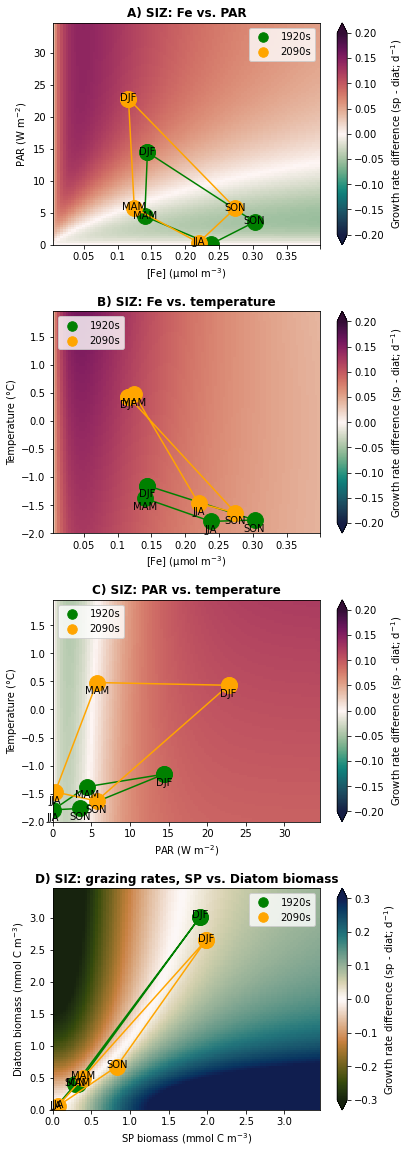

In [40]:
fig = plt.figure(figsize=(6,20))

######################################################### SIZ Fe versus PAR
ax = fig.add_subplot(4,1,1)

ax.set_title('A) SIZ: Fe vs. PAR',x=0.5,y=1, fontsize=12, fontweight='bold',ha='center')
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_FePAR_SIZ2090s-diat_growthrate_FePAR_SIZ2090s,cmap=cmocean.cm.curl,vmin=-0.2,vmax=0.2)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')

#1920s
#s = [ACC_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_1920s.Fe_avg_50m.values,SIZ_plotvals_1920s.PAR_avg_50m.values,
        marker='o',s=250,color='green',label='1920s', zorder=1)
ax.plot(SIZ_plotvals_1920s.Fe_avg_50m.values,SIZ_plotvals_1920s.PAR_avg_50m.values,
        color='green',zorder=1)

# #2090s
#s = [ACC_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_2090s.Fe_avg_50m.values,SIZ_plotvals_2090s.PAR_avg_50m.values,
        marker='o',s=250,color='orange',label='2090s',zorder=2)
ax.plot(SIZ_plotvals_2090s.Fe_avg_50m.values,SIZ_plotvals_2090s.PAR_avg_50m.values,
        color='orange',zorder=2)

## add season labels
plt.annotate(annotations[0], (ds_siz_1920s.Fe_avg_50m.values[0], ds_siz_1920s.PAR_avg_50m.values[0]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_1920s.Fe_avg_50m.values[1], ds_siz_1920s.PAR_avg_50m.values[1]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_1920s.Fe_avg_50m.values[2], ds_siz_1920s.PAR_avg_50m.values[2]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_1920s.Fe_avg_50m.values[3], ds_siz_1920s.PAR_avg_50m.values[3]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[0], (ds_siz_2090s.Fe_avg_50m.values[0], ds_siz_2090s.PAR_avg_50m.values[0]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_2090s.Fe_avg_50m.values[1], ds_siz_2090s.PAR_avg_50m.values[1]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_2090s.Fe_avg_50m.values[2], ds_siz_2090s.PAR_avg_50m.values[2]-0.3), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_2090s.Fe_avg_50m.values[3], ds_siz_2090s.PAR_avg_50m.values[3]-0.3), fontsize=10,ha='center')

ax.legend(markerscale=0.6,scatterpoints=1, fontsize=10)
# ### add x axis labels in nmol/m3
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35']
ax.set_xticklabels(labels)

# ### color base
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
# fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');
fig.colorbar(pc,  extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');




######################################################### Fe versus temperature
ax = fig.add_subplot(4,1,2)

ax.set_title('B) SIZ: Fe vs. temperature',x=0.5,y=1, fontsize=12, fontweight='bold',ha='center')
pc=ax.pcolormesh(Fe_vals, Temp_vals, sp_growthrate_FeT_SIZ2090s-diat_growthrate_FeT_SIZ2090s,cmap=cmocean.cm.curl,vmin=-0.2,vmax=0.2)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('[Fe] (µmol m$^{-3}$)')

#1920s
#s = [ACC_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_1920s.Fe_avg_50m.values,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        marker='o',s=250,color='green',label='1920s', zorder=1)
ax.plot(SIZ_plotvals_1920s.Fe_avg_50m.values,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        color='green',zorder=1)

# #2090s
#s = [ACC_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_2090s.Fe_avg_50m.values,SIZ_plotvals_2090s.TEMP_50m_mean.values,
        marker='o',s=250,color='orange',label='2090s',zorder=2)
ax.plot(SIZ_plotvals_2090s.Fe_avg_50m.values,SIZ_plotvals_2090s.TEMP_50m_mean.values,
        color='orange',zorder=2)

## add season labels
plt.annotate(annotations[0], (ds_siz_1920s.Fe_avg_50m.values[0], ds_siz_1920s.TEMP_50m_mean.values[0]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_1920s.Fe_avg_50m.values[1], ds_siz_1920s.TEMP_50m_mean.values[1]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_1920s.Fe_avg_50m.values[2], ds_siz_1920s.TEMP_50m_mean.values[2]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_1920s.Fe_avg_50m.values[3], ds_siz_1920s.TEMP_50m_mean.values[3]-0.2), fontsize=10,ha='center')

plt.annotate(annotations[0], (ds_siz_2090s.Fe_avg_50m.values[0], ds_siz_2090s.TEMP_50m_mean.values[0]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_2090s.Fe_avg_50m.values[1], ds_siz_2090s.TEMP_50m_mean.values[1]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_2090s.Fe_avg_50m.values[2], ds_siz_2090s.TEMP_50m_mean.values[2]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_2090s.Fe_avg_50m.values[3], ds_siz_2090s.TEMP_50m_mean.values[3]-0.2), fontsize=10,ha='center')

ax.legend(loc="upper left",markerscale=0.6,scatterpoints=1, fontsize=10)
### add x axis labels in µmol/m3
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35']
ax.set_xticklabels(labels)

### color base
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
# fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');
fig.colorbar(pc,  extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');


######################################################### ACC PAR versus TEMP
ax = fig.add_subplot(4,1,3)

ax.set_title('C) SIZ: PAR vs. temperature',x=0.5,y=1, fontsize=12, fontweight='bold',ha='center')
pc=ax.pcolormesh(PAR_vals, Temp_vals, sp_growthrate_PART_SIZ2090s-diat_growthrate_PART_SIZ2090s,cmap=cmocean.cm.curl,vmin=-0.2,vmax=0.2)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('PAR (W m$^{-2}$)')

#1920s
#s = [ACC_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_1920s.PAR_avg_50m.values,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        marker='o',s=250,color='green',label='1920s', zorder=1)
ax.plot(SIZ_plotvals_1920s.PAR_avg_50m.values,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        color='green',zorder=1)

# #2090s
#s = [ACC_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_2090s.PAR_avg_50m.values,SIZ_plotvals_2090s.TEMP_50m_mean.values,
        marker='o',s=250,color='orange',label='2090s',zorder=2)
ax.plot(SIZ_plotvals_2090s.PAR_avg_50m.values,SIZ_plotvals_2090s.TEMP_50m_mean.values,
        color='orange',zorder=2)

## add season labels
plt.annotate(annotations[0], (ds_siz_1920s.PAR_avg_50m.values[0], ds_siz_1920s.TEMP_50m_mean.values[0]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_1920s.PAR_avg_50m.values[1], ds_siz_1920s.TEMP_50m_mean.values[1]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_1920s.PAR_avg_50m.values[2], ds_siz_1920s.TEMP_50m_mean.values[2]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_1920s.PAR_avg_50m.values[3], ds_siz_1920s.TEMP_50m_mean.values[3]-0.2), fontsize=10,ha='center')

plt.annotate(annotations[0], (ds_siz_2090s.PAR_avg_50m.values[0], ds_siz_2090s.TEMP_50m_mean.values[0]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[1], (ds_siz_2090s.PAR_avg_50m.values[1], ds_siz_2090s.TEMP_50m_mean.values[1]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[2], (ds_siz_2090s.PAR_avg_50m.values[2], ds_siz_2090s.TEMP_50m_mean.values[2]-0.2), fontsize=10,ha='center')
plt.annotate(annotations[3], (ds_siz_2090s.PAR_avg_50m.values[3], ds_siz_2090s.TEMP_50m_mean.values[3]-0.2), fontsize=10,ha='center')

ax.legend(loc="upper left",markerscale=0.6,scatterpoints=1, fontsize=10)

### color base
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
# fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');
fig.colorbar(pc,  extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');



######################################################### ACC grazing rate diffs
ax = fig.add_subplot(4,1,4)

ax.set_title('D) SIZ: grazing rates, SP vs. Diatom biomass',x=0.5,y=1, fontsize=12, fontweight='bold',ha='center')
pc=ax.pcolormesh(spC_vals, diatC_vals, sp_grazingrate_siz2090s-diat_grazingrate_siz2090s,cmap=cmocean.cm.tarn,vmin=-0.3,vmax=0.3)
ax.set_xlabel('SP biomass (mmol C m$^{-3}$)')
ax.set_ylabel('Diatom biomass (mmol C m$^{-3}$)')

#1920s
#s = [ACC_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_1920s.spC_50m_zint.values/50.,SIZ_plotvals_1920s.diatC_50m_zint.values/50.,
        marker='o',s=250,color='green',label='1920s', zorder=1)
ax.plot(SIZ_plotvals_1920s.spC_50m_zint.values/50.,SIZ_plotvals_1920s.diatC_50m_zint.values/50.,
        color='green',zorder=1)

# #2090s
#s = [ACC_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_2090s.spC_50m_zint.values/50.,SIZ_plotvals_2090s.diatC_50m_zint.values/50.,
        marker='o',s=250,color='orange',label='2090s',zorder=2)
ax.plot(SIZ_plotvals_2090s.spC_50m_zint.values/50.,SIZ_plotvals_2090s.diatC_50m_zint.values/50.,
        color='orange',zorder=2)

## add season labels
plt.annotate(annotations[0], (ds_siz_1920s.spC_50m_zint.values[0]/50., ds_siz_1920s.diatC_50m_zint.values[0]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_siz_1920s.spC_50m_zint.values[1]/50., ds_siz_1920s.diatC_50m_zint.values[1]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_siz_1920s.spC_50m_zint.values[2]/50., ds_siz_1920s.diatC_50m_zint.values[2]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_siz_1920s.spC_50m_zint.values[3]/50., ds_siz_1920s.diatC_50m_zint.values[3]/50.-0.02), fontsize=10, ha='center')

plt.annotate(annotations[0], (ds_siz_2090s.spC_50m_zint.values[0]/50., ds_siz_2090s.diatC_50m_zint.values[0]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_siz_2090s.spC_50m_zint.values[1]/50., ds_siz_2090s.diatC_50m_zint.values[1]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_siz_2090s.spC_50m_zint.values[2]/50., ds_siz_2090s.diatC_50m_zint.values[2]/50.-0.02), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_siz_2090s.spC_50m_zint.values[3]/50., ds_siz_2090s.diatC_50m_zint.values[3]/50.-0.02), fontsize=10, ha='center')

ax.legend(markerscale=0.6,scatterpoints=1, fontsize=10)


fig.subplots_adjust(hspace=0.3)
# ### color base
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
# fig.colorbar(pc, cax=cbar_ax, extend='both', label='Grazing rate difference (sp - diat; d$^{-1}$)');
fig.colorbar(pc,  extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');